In [1]:
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.layers import LSTM, Dense, Dropout, Input, Conv1D, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'  # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])
# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg', 'value_mxn',
                   '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', '5.0782242_m',
                   '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
data = data[columns_to_keep]

# Filtrar los datos para obtener una especie y un clúster específico
species_name = 'PARGO'  # Cambia esto a la especie que deseas usar
cluster_label = 1  # Cambia esto al clúster que deseas usar
filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]

# Ordenar por fecha
filtered_data = filtered_data.sort_values('date')

# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y, scaler


2024-07-03 05:05:29.967317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 05:05:29.970855: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-03 05:05:30.018434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 05:05:30.018468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 05:05:30.019714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data['species'].unique()

array(['MOJARRA', 'OTRAS', 'LOBINA', 'GUACHINANGO', 'PARGO', 'BANDERA',
       'CORVINA', 'SIERRA', 'LANGOSTA', 'PULPO', 'OSTION', 'TIBURON',
       'ROBALO', 'JUREL', 'BAQUETA', 'RAYA Y SIMILARES', 'RONCO',
       'LENGUADO', 'BERRUGATA', 'ESMEDREGAL', 'PAMPANO', 'CAZON',
       'CABRILLA', 'MERO', 'JAIBA', 'LISA', 'CALAMAR', 'CARACOL',
       'ALMEJA', 'LANGOSTINO', 'LEBRANCHA', 'RUBIA Y VILLAJAIBA',
       'CHARAL', 'PIERNA', 'CAMARON', 'PEPINO DE MAR', 'ALGAS',
       'MACARELA', 'SARDINA', 'ATUN', 'BONITO', 'ERIZO', 'BARRILETE',
       'FAUNA', 'RUBIO', 'SARGAZO', 'ANCHOVETA', 'PETO', 'CINTILLA',
       'ABULON', 'BESUGO'], dtype=object)

In [27]:
# Crear el modelo LSTM
def create_lstm_model(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(25, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(12, activation='linear')(x)
    lstm_output = Dense(1, activation='linear')(x)
    return Model(inputs=lstm_input, outputs=lstm_output)

# Crear el modelo DNN
def create_dnn_model(input_shape):
    dnn_input = Input(shape=(input_shape[0], input_shape[1]))
    x = Flatten()(dnn_input)
    x = Dense(10, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    dnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=dnn_input, outputs=dnn_output)

# Crear el modelo CNN
def create_cnn_model(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu')(cnn_input)
    x = Flatten()(x)
    cnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=cnn_input, outputs=cnn_output)

# Crear el modelo Mixture of Experts (MoE)
def create_moe_model(input_shape):
    # Definir los expertos
    lstm_model = create_lstm_model(input_shape)
    dnn_model = create_dnn_model(input_shape)
    cnn_model = create_cnn_model(input_shape)
    
    # Definir el gating network
    moe_input = Input(shape=input_shape)
    x = Flatten()(moe_input)
    x = Dense(10, activation='relu')(x)
    gate_output = Dense(3, activation='softmax')(x)  # Tres expertos

    # Obtener las salidas de los expertos
    lstm_output = lstm_model(moe_input)
    dnn_output = dnn_model(moe_input)
    cnn_output = cnn_model(moe_input)
    
    # Combinar las salidas usando el gating network
    output = concatenate([lstm_output * gate_output[:, 0:1],
                          dnn_output * gate_output[:, 1:2],
                          cnn_output * gate_output[:, 2:3]], axis=1)
    output = Dense(1, activation='linear')(output)
    
    model = Model(inputs=moe_input, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Función para entrenar y guardar el modelo MoE
def train_and_save_moe_model(data, species_name, look_back=look_back, epochs=50, batch_size=1):
    X, y, scaler = prepare_data(data, look_back)
    model = create_moe_model((look_back, X.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo y el scaler
    model_directory = 'modelos_moe'
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_moe_model.h5')
    scaler_path = os.path.join(model_directory, f'{species_name}_moe_scaler.pkl')
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f'Modelo MoE y scaler guardados para {species_name}')
    return model, scaler


In [28]:

# Entrenar el modelo MoE
model, scaler = train_and_save_moe_model(filtered_data, species_name, look_back)


Epoch 1/50
13066/13066 [==============================] - 74s 5ms/step - loss: 7.2567e-04 - val_loss: 7.3532e-04
Epoch 2/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.6953e-04 - val_loss: 6.6719e-04
Epoch 3/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.4931e-04 - val_loss: 6.2542e-04
Epoch 4/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.4077e-04 - val_loss: 6.5140e-04
Epoch 5/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.3496e-04 - val_loss: 5.9351e-04
Epoch 6/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.3566e-04 - val_loss: 6.1193e-04
Epoch 7/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.3148e-04 - val_loss: 6.4817e-04
Epoch 8/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.3186e-04 - val_loss: 8.1744e-04
Epoch 9/50
13066/13066 [==============================] - 68s 5ms/step - loss: 6.3419e-04 - val_

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 0s 3ms/step
MSE Mensual: 15926165.416970981, R2 Mensual: 0.9144155392157636


/var/tmp/ipykernel_42001/1300594459.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


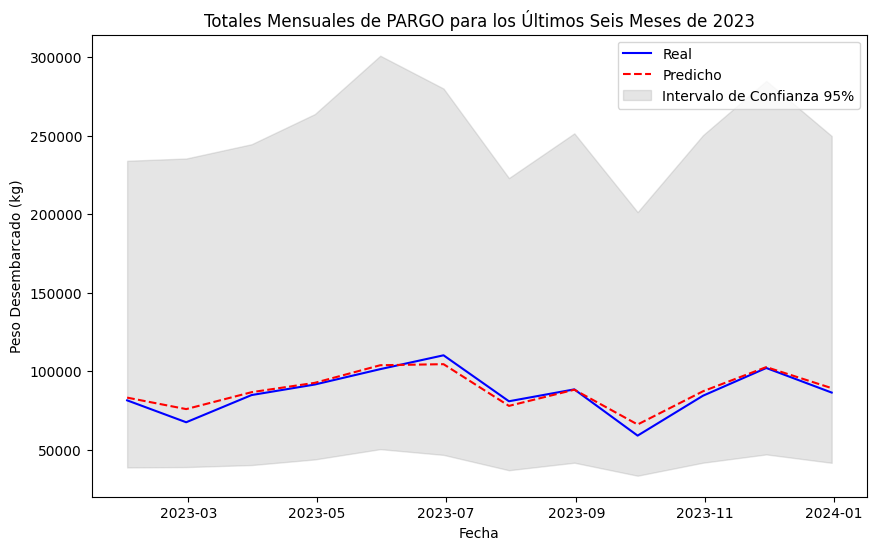

In [30]:
# Función para hacer predicciones con bandas de confianza usando bootstrap
def predict_with_confidence_intervals(species_name, data, look_back=6, n_bootstrap=100, alpha=0.01):
    model_path = f'modelos_moe/{species_name}_moe_model.h5'
    scaler_path = f'modelos_moe/{species_name}_moe_scaler.pkl'
    
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    group_scaled = scaler.transform(data[features])

    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, X[:, -1, 1:])))[:, 0]
    
    # Bootstrap para bandas de confianza
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(range(len(X)), len(X), replace=True)
        X_sample = X[indices]
        pred_sample = model.predict(X_sample)
        pred_sample = scaler.inverse_transform(np.hstack((pred_sample, X_sample[:, -1, 1:])))[:, 0]
        bootstrap_predictions.append(pred_sample)
    
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    
    return predictions, lower_bound, upper_bound

# Filtrar los datos para los últimos seis meses de 2023 y realizar predicciones con bandas de confianza
test_data_2023 = filtered_data[(filtered_data['date'].dt.year == 2023) & (filtered_data['date'].dt.month >= 1)]
if len(test_data_2023) >= look_back:
    predictions, lower_bound, upper_bound = predict_with_confidence_intervals(species_name, test_data_2023, look_back)
    real_values = test_data_2023['landed_w_kg'].values[look_back:]
    
    # Crear un DataFrame para los resultados
    results_df = pd.DataFrame({
        'date': test_data_2023['date'].values[look_back:],
        'real_values': real_values,
        'predictions': predictions,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
    
    # Agrupar por mes y sumar los valores
    monthly_totals = results_df.set_index('date').resample('M').sum()
    
    # Calcular MSE y R2 para los totales mensuales
    mse = mean_squared_error(monthly_totals['real_values'], monthly_totals['predictions'])
    r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
    print(f'MSE Mensual: {mse}, R2 Mensual: {r2}')
    
    # Crear figura
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_totals.index, monthly_totals['real_values'], color='blue', label='Real')
    plt.plot(monthly_totals.index, monthly_totals['predictions'], color='red', linestyle='--', label='Predicho')
    plt.fill_between(monthly_totals.index, monthly_totals['lower_bound'], monthly_totals['upper_bound'], color='gray', alpha=0.2, label='Intervalo de Confianza 95%')
    plt.title(f'Totales Mensuales de {species_name} para los Últimos Seis Meses de 2023')
    plt.xlabel('Fecha')
    plt.ylabel('Peso Desembarcado (kg)')
    plt.legend()
    plt.show()
else:
    print(f'No se tienen datos suficientes para {species_name} en los últimos seis meses de 2023')




